In [6]:
import numpy as np
import struct
from functools import reduce
from scipy.optimize import minimize
from matplotlib import pyplot as plt

In [7]:
HIDDEN_LAYER_SIZE = 25
SAMPLES_TO_TRAIN = 1000
SAMPLES_TO_TEST = 100



def one_hot_encode(y):

    # Функция кодирует вектор чисел с метками классов в матрицу, каждая строка которой является унитарным кодом
    # соответствующей метки.
    return np.array(np.arange(0, 10, 1) == y, dtype=np.int32)

def logistic(z):
    result = 1 / (1 + (pow(np.e, (-z))))
    return result


def logistic_grad(z):
    fx = logistic(z)
    result = fx * (1 - fx)
    return result

In [8]:
def compute_hypothesis(X, theta):

    Theta1 = theta[:HIDDEN_LAYER_SIZE * (X.shape[1] + 1)].reshape(HIDDEN_LAYER_SIZE, X.shape[1] + 1)
    Theta2 = theta[HIDDEN_LAYER_SIZE * (X.shape[1] + 1):].reshape(10, HIDDEN_LAYER_SIZE + 1)

    
    b = np.ones((X.shape[0], 1))                           # смещение
    X_1 = np.concatenate([b, X], axis=1)                   # X со смещением
    
    Z2 = Theta1 @ X_1.T                                    # ВХОД В СКРЫТЫЙ СЛОЙ и суммирование

    A2 = logistic(Z2)                                      # функция активации (Выход из скрытого слоя)
    A2_1 = np.concatenate([np.ones((1,A2.shape[1])), A2])  # добавление смещения (Выход из скрытого слоя)

    Z3 = Theta2 @ A2_1                                     # ВХОД В ВЫХОДНОЙ СЛОЙ

    H = logistic(Z3)       
                            

    return Z2, A2_1, H

In [9]:
def compute_cost111(X, y, theta, lamb):


    m, n = X.shape  # m - количество примеров в выборке, n - количество признаков у каждого примера
    cost_total = []  # значение функции стоимости при заданных параметрах, его нужно посчитать
    cost2 = []
    Theta1 = theta[:HIDDEN_LAYER_SIZE * (X.shape[1] + 1)].reshape(HIDDEN_LAYER_SIZE, X.shape[1] + 1)
    Theta2 = theta[HIDDEN_LAYER_SIZE * (X.shape[1] + 1):].reshape(10, HIDDEN_LAYER_SIZE + 1)
    theta1_0 = np.delete(Theta1, 0, axis=1)
    theta2_0 = np.delete(Theta2, 0, axis=1)
    H = compute_hypothesis(X, theta)[2]
    for j in range(m):
        for k in range(10):
            cost = (one_hot_encode(y[j])[k] * (np.log(H[k, j])) + (1 - one_hot_encode(y[j])[k]) * np.log(1 - (H[k, j])))
            cost_total.append(cost)
            
    reg = (lamb/(2 * m)) * (np.sum(pow(theta1_0, 2)) + np.sum(pow(theta2_0, 2)))

    return (np.sum(np.array(cost_total))) * (-1/m) + reg

# оптимизировал

In [10]:
def compute_cost(X, y, theta, lamb):


    m, n = X.shape  # m - количество примеров в выборке, n - количество признаков у каждого примера
    cost_total = []  # значение функции стоимости при заданных параметрах, его нужно посчитать
    cost2 = []
    Theta1 = theta[:HIDDEN_LAYER_SIZE * (X.shape[1] + 1)].reshape(HIDDEN_LAYER_SIZE, X.shape[1] + 1)
    Theta2 = theta[HIDDEN_LAYER_SIZE * (X.shape[1] + 1):].reshape(10, HIDDEN_LAYER_SIZE + 1)
    theta1_0 = np.delete(Theta1, 0, axis=1)
    theta2_0 = np.delete(Theta2, 0, axis=1)
    H = compute_hypothesis(X, theta)[2]
    for j in range(m):
        cost = (one_hot_encode(y[j]) * (np.log(H[:,j])) + (1 - one_hot_encode(y[j])) * np.log(1 - (H[:, j])))
        cost_total.append(cost)
            
    reg = (lamb/(2 * m)) * (np.sum(pow(theta1_0, 2)) + np.sum(pow(theta2_0, 2)))

    return (np.sum(np.array(cost_total))) * (-1/m) + reg

In [11]:
def compute_cost_grad_approx(X, y, theta, lamb):

    # Фукнция для численного расчета градиента фукници стоимости. Такой метод полезно использовать при проверке
    # правильности аналитического расчета.

    eps = 1e-5
    grad = np.zeros(theta.size)
    perturb = np.zeros(theta.size)
    for i in range(theta.shape[0]):
        if i % 1000 == 0:
            print(f'{round(i / theta.shape[0] * 100, 2)}%')
        perturb[i] = eps
        grad[i] = (compute_cost(X, y, theta + perturb, lamb) - compute_cost(X, y, theta - perturb, lamb)) / (2 * eps)
        perturb[i] = 0
    return grad

In [12]:
def compute_cost_grad(X, y, theta, lamb):

    # Функция принимает матрицу данных X без фиктивного признака, вектор верных классов y,
    # вектор параметров theta и параметр регуляризации lamb.
    # Вектор theta является "разворотом" мартиц Theta1 и Theta2 в плоский вектор.
    # Функция должна реализовать алгоритм обратного распространения ошибки и вернуть матрицы градиентов весов связей.

    m, n = X.shape  # m - количество примеров в выборке, n - количество признаков у каждого примера
    # Восстановление матриц Theta1 и Theta2 из ветора theta:
    Theta1 = theta[:HIDDEN_LAYER_SIZE * (X.shape[1] + 1)].reshape(HIDDEN_LAYER_SIZE, X.shape[1] + 1)
    Theta2 = theta[HIDDEN_LAYER_SIZE * (X.shape[1] + 1):].reshape(10, HIDDEN_LAYER_SIZE + 1)
    theta1_0 = np.delete(Theta1, 0, axis=1)
    theta2_0 = np.delete(Theta2, 0, axis=1)
    
    H = compute_hypothesis(X, theta)[2]
    Z2 = compute_hypothesis(X, theta)[0]
    A2 = compute_hypothesis(X, theta)[1]
    #np.concatenate([Theta1[:, 0].reshape(Theta1.shape[0], 1), lamb/m * theta1_0], axis=1)
    #np.concatenate([Theta2[:, 0].reshape(Theta2.shape[0], 1), lamb/m * theta2_0], axis=1)
    grad1 = 0
    grad2 = 0

    b = np.ones((X.shape[0], 1))  # смещение
    X_1 = np.concatenate([b, X], axis=1)
    for j in range(X.shape[0]):
        delta3 = H[:, j] - one_hot_encode(y[j])
        delta2 = (Theta2.T @ delta3) * np.concatenate([np.ones((1, Z2.shape[1])), logistic_grad(Z2)], axis=0)[:, j]
        delta2_0 = np.delete(delta2, 0, axis=0)
        
        #grad1 = X_1[j].reshape(X_1.shape[1], 1) @ delta2_0.reshape(1, delta2_0.shape[0])
        grad1_0 = np.array([X_1[j]]).T @ np.array([delta2_0])
        
        grad1 += grad1_0       # Будущая матрица градиентов весов между входным и скрытым слоем, ее нужно заполнить
        
        #grad2 = A2[j].reshape(A2.shape[1], 1) @ delta3.reshape(1, delta3.shape[0])
        grad2_0 = np.array([A2[:, j]]).T @ np.array([delta3])

        grad2 += grad2_0       # Будущая матрица градиентов весов между скрытым и выходным слоем, ее нужно заполнить

    Theta1_reg_grad = 1 / m * grad1.T[:,1:] + (lamb/m) * Theta1[:,1:]
    Theta1_grad = np.concatenate(((1/m) * grad1.T[:,:1], Theta1_reg_grad), axis = 1)
    
    Theta2_reg_grad = 1 / m * grad2.T[:,1:] + (lamb/m) * Theta2[:,1:]
    Theta2_grad = np.concatenate(((1/m) * grad2.T[:,:1], Theta2_reg_grad), axis = 1)



    # ВАШ КОД ЗДЕСЬ

    # ==============

    return np.concatenate((Theta1_grad, Theta2_grad), axis=None)

In [13]:
def load_data_idx(file_path):
    with open(file_path, 'rb') as input_file:
        magic = input_file.read(4)
        dims = int(magic[3])
        sizes = [struct.unpack('>L', input_file.read(4))[0] for _ in range(dims)]
        size = reduce(lambda x, y: x * y, sizes)
        data = np.array(list(input_file.read(size)), dtype=float)
        data = data.reshape(sizes)
        return data

In [18]:
images = load_data_idx('images.idx')

features = images.reshape((images.shape[0], images.shape[1] * images.shape[2])) / 128 - 1.0

labels = load_data_idx('labels.idx')

X = features[:SAMPLES_TO_TRAIN]
y = labels[:SAMPLES_TO_TRAIN]

X_test = features[SAMPLES_TO_TRAIN: SAMPLES_TO_TRAIN + SAMPLES_TO_TEST]
y_test = labels[SAMPLES_TO_TRAIN: SAMPLES_TO_TRAIN + SAMPLES_TO_TEST]


init_Theta1 = np.random.uniform(-0.12, 0.12, (HIDDEN_LAYER_SIZE, X.shape[1] + 1))
init_Theta2 = np.random.uniform(-0.12, 0.12, (10, HIDDEN_LAYER_SIZE + 1))

init_theta = np.concatenate((init_Theta1, init_Theta2), axis=None)


lamb = 1

In [ ]:
back_prop_grad = compute_cost_grad(X[:10], y[:10], init_theta, 0)

print('Запуск численного расчета градиента (может занять какое-то время)')
num_grad = compute_cost_grad_approx(X[:10], y[:10], init_theta, 0)

print('Градиент, посчитанный аналитически: ')
print(back_prop_grad)

print('Градиент, посчитанный численно (должен примерно совпадать с предыдущим): ')
print(num_grad)

print()
print('Относительное отклоение градиентов (должно быть < 1e-7): ')
print((np.linalg.norm(back_prop_grad - num_grad) / np.linalg.norm(back_prop_grad + num_grad)))

In [23]:
print('Запуск оптимизации параметров сети (может занять какое-то время)')
opt_theta_obj = minimize(lambda th: compute_cost(X, y, th, lamb), init_theta,
                         method='CG',
                         jac=lambda th: compute_cost_grad(X, y, th, lamb),
                         options={'gtol': 1e-3, 'maxiter': 3000, 'disp': False})

print('Минимизация функции стоимости ' + ('прошла успешно.' if opt_theta_obj.success else 'не удалась.'))

opt_theta = opt_theta_obj.x

print(opt_theta_obj)

Запуск оптимизации параметров сети (может занять какое-то время)
Минимизация функции стоимости прошла успешно.
     fun: 0.42655465457583364
     jac: array([ 6.55138459e-04, -6.50463304e-04, -6.65969287e-04, ...,
       -2.83442312e-05, -5.10165090e-04,  4.28019636e-04])
 message: 'Optimization terminated successfully.'
    nfev: 353
     nit: 237
    njev: 353
  status: 0
 success: True
       x: array([ 0.01046519,  0.00467515, -0.01083083, ..., -0.44935394,
        0.79780785,  2.86185168])


In [24]:
print('Функция стоимости при оптимальных параметрах (должна быть < 0.5): ')
print(compute_cost(X, y, opt_theta, lamb))


Функция стоимости при оптимальных параметрах (должна быть < 0.5): 
0.42655465457583364


In [25]:
hypos_train = compute_hypothesis(X, opt_theta)[2].T
true_preds_train_num = 0
for k in range(hypos_train.shape[0]):
    max_el = np.max(hypos_train[k, :])
    true_preds_train_num += list(np.array(hypos_train[k, :] == max_el, dtype=np.int32)) == list(one_hot_encode(y[k]))
print('Доля верно распознаных цифр в обучающем наборе:', true_preds_train_num / hypos_train.shape[0] * 100, '%')

Доля верно распознаных цифр в обучающем наборе: 99.8 %


In [26]:
hypos_test = compute_hypothesis(X_test, opt_theta)[2].T

true_preds_test_num = 0
for k in range(hypos_test.shape[0]):
    max_el = np.max(hypos_test[k, :])
    true_preds_test_num += list(np.array(hypos_test[k, :] == max_el, dtype=np.int32)) == list(one_hot_encode(y_test[k]))
print('Доля верно распознаных цифр в тестовом наборе:', true_preds_test_num / hypos_test.shape[0] * 100, '%')

Доля верно распознаных цифр в тестовом наборе: 83.0 %


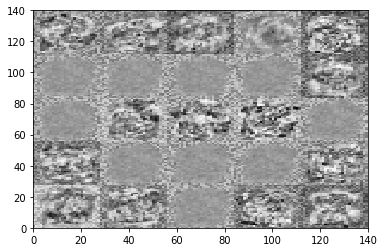

In [27]:
if HIDDEN_LAYER_SIZE ** 0.5 % 1.0 == 0:
    Theta1 = opt_theta[:HIDDEN_LAYER_SIZE * (X.shape[1] + 1)].reshape(HIDDEN_LAYER_SIZE, X.shape[1] + 1)
    Theta1 = Theta1[:, 1:]
    Theta1 = (Theta1 - Theta1.mean(axis=0)) / (Theta1.std(axis=0))
    Theta1 = Theta1.reshape(HIDDEN_LAYER_SIZE, 28, 28)
    im_size = int(features.shape[1] ** 0.5)
    size_imgs = int(HIDDEN_LAYER_SIZE ** 0.5)
    hm = np.zeros((im_size * size_imgs, im_size * size_imgs))
    for i in range(HIDDEN_LAYER_SIZE):
        im_x = i % size_imgs * im_size
        im_y = i // size_imgs * im_size
        for j in range(features.shape[1]):
            px_x = im_x + j % im_size
            px_y = im_y + j // im_size
            hm[size_imgs * im_size - 1 - px_x, px_y] = Theta1[i, j % im_size, j // im_size]
    plt.pcolor(hm, cmap='Greys')
    plt.show()

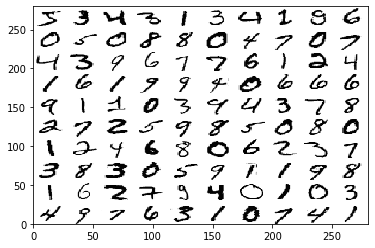

In [28]:
im_size = int(features.shape[1] ** 0.5)
hm = np.zeros((im_size * 10, im_size * 10))
for i in range(100):
    im_x = i % 10 * im_size
    im_y = i // 10 * im_size
    for j in range(features.shape[1]):
        px_x = im_x + j % im_size
        px_y = im_y + j // im_size
        hm[10 * im_size - 1 - px_x, px_y] = images[i, j % im_size, j // im_size]
plt.pcolor(hm, cmap='Greys')
plt.show()


In [345]:

v = pow(init_Theta1,2)
sum1 = (np.sum(v))

In [346]:
g = pow(init_Theta2,2)
sum2 = (np.sum(g))

In [358]:
(sum1+sum2) * (lamb / (2 * m))

0.02404788234794263

In [374]:
(sum1+sum2) * (lamb / 2 * m)

24047.88234794263

In [36]:
one_hot_encode(y[0])

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [21]:
init_Theta1.shape

(25, 785)

In [23]:
X.shape

(1000, 784)